In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ast
import math

from scipy.constants import g

In [2]:
WIDTH = 1800
HEIGHT = 800

AIRCRAFT_SIZE = 24
COLLISION_RADIUS = 2 * AIRCRAFT_SIZE
GOAL_RADIUS = 5 * AIRCRAFT_SIZE
SAFE_DISTANCE = 4 * COLLISION_RADIUS

PLAYER_X = COLLISION_RADIUS
PLAYER_Y = HEIGHT / 2

GOAL_X = WIDTH - GOAL_RADIUS
GOAL_Y = HEIGHT / 2

# KINEMATICS CONSTANTS
AIRSPEED = 200
ACC_LAT_LIMIT = 20 * g

In [3]:
# Load simulation data
simulation_data_file = "../gym_ACAS2D/models/logs/testing_ACAS2D_PPO_1048576_8_100.csv"
simulation = pd.read_csv(simulation_data_file)

# Convert list records
simulation["Path"] = simulation.apply(lambda row: ast.literal_eval(row["Path"]), axis=1)
simulation["Traffic Paths"] = simulation.apply(lambda row: ast.literal_eval(row["Traffic Paths"]), axis=1)
simulation["psi"] = simulation.apply(lambda row: ast.literal_eval(row["psi"]), axis=1)
simulation["d_sep"] = simulation.apply(lambda row: ast.literal_eval(row["d_sep"]), axis=1)
simulation["a_lat"] = simulation.apply(lambda row: ast.literal_eval(row["a_lat"]), axis=1)
simulation["d_goal"] = simulation.apply(lambda row: ast.literal_eval(row["d_goal"]), axis=1)
simulation["delta_heading"] = simulation.apply(lambda row: ast.literal_eval(row["delta_heading"]), axis=1)
simulation["v_closing"] = simulation.apply(lambda row: ast.literal_eval(row["v_closing"]), axis=1)
simulation["d_cpa"] = simulation.apply(lambda row: ast.literal_eval(row["d_cpa"]), axis=1)
simulation["d_dev"] = simulation.apply(lambda row: ast.literal_eval(row["d_dev"]), axis=1)
simulation["r_d_goal"] = simulation.apply(lambda row: ast.literal_eval(row["r_d_goal"]), axis=1)
simulation["r_h_goal"] = simulation.apply(lambda row: ast.literal_eval(row["r_h_goal"]), axis=1)
simulation["r_d_cpa"] = simulation.apply(lambda row: ast.literal_eval(row["r_d_cpa"]), axis=1)
simulation["r_d_dev"] = simulation.apply(lambda row: ast.literal_eval(row["r_d_dev"]), axis=1)
simulation["r_step"] = simulation.apply(lambda row: ast.literal_eval(row["r_step"]), axis=1)

# Confirm that all list records have the right length, equal to the TIME_STEPS of the corresponding episode
for index, row in simulation.iterrows():
    assert len(row["Path"]) == len(row["Traffic Paths"][0]) == \
           len(row["psi"]) == len(row["a_lat"]) == \
           len(row["d_sep"]) == len(row["d_goal"]) == \
           len(row["delta_heading"]) == len(row["v_closing"]) ==\
           len(row["d_cpa"]) == len(row["d_dev"]) == row["Time Steps"] == \
           len(row["r_d_goal"]) == len(row["r_h_goal"]) == \
           len(row["r_d_cpa"]) == len(row["r_d_dev"]) ==\
           len(row["r_step"]) == \
           row["Time Steps"]

simulation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Episode        100 non-null    int64  
 1   Outcome        100 non-null    object 
 2   Total Reward   100 non-null    float64
 3   Time Steps     100 non-null    int64  
 4   Path Length    100 non-null    float64
 5   Path           100 non-null    object 
 6   Traffic Paths  100 non-null    object 
 7   psi            100 non-null    object 
 8   d_sep          100 non-null    object 
 9   a_lat          100 non-null    object 
 10  d_goal         100 non-null    object 
 11  delta_heading  100 non-null    object 
 12  v_closing      100 non-null    object 
 13  d_cpa          100 non-null    object 
 14  d_dev          100 non-null    object 
 15  r_d_goal       100 non-null    object 
 16  r_h_goal       100 non-null    object 
 17  r_d_cpa        100 non-null    object 
 18  r_d_dev    

In [4]:
simulation.head()

,Episode,Outcome,Total Reward,Time Steps,Path Length,Path,Traffic Paths,psi,d_sep,a_lat,d_goal,delta_heading,v_closing,d_cpa,d_dev,r_d_goal,r_h_goal,r_d_cpa,r_d_dev,r_step
0,1,Goal,1277.140226,827,1652.0,"[(48, 400.0), (49.99640074694916, 400.11993355...","[[(1152.0, 48), (1152.0, 48), (1150.2399161312...","[2.4572408207095524, 3.4379058207095525, 3.587...","[1158.757955743994, 1156.8925535127953, 1153.0...","[0, 196.13299999999998, 29.934003099709745, 29...","[1632.0, 1630.0036036653287, 1628.007537059225...","[2.4572408207095524, 3.4421215699914, 3.596201...","[-384.3032110710322, -383.07203973094107, -382...","[-95.6870853807643, -105.56614633552599, -107....","[0.0, -0.11993355485957463, -0.245081761616836...","[0.22415016443859734, 0.22464779215291736, 0.2...","[0.9465026611158013, 0.9256746827161333, 0.922...","[0.06168909372269452, 0.09138896467669734, 0.0...","[1.0, 0.9999265086016765, 0.9998498160743448, ...","[0.058388891370352435, 0.08449624462075664, 0...."
1,2,Collision,-996.424182,341,680.0,"[(48, 400.0), (49.99975594972326, 399.96875673...","[[(1152.0, 48), (1152.0, 48), (1150.6218659473...","[358.1242450086868, 359.1049100086868, 0.08557...","[1158.757955743994, 1156.843353097187, 1153.18...","[0, 196.13299999999998, 196.13299999999998, 19...","[1632.0, 1630.0002443497067, 1628.000246526226...","[1.8757549913132152, 0.8961882164040844, 0.084...","[-367.7500026145592, -366.7687857955226, -365....","[130.67948769168035, 120.82153144575149, 110.9...","[0.0, 0.031243264016893587, 0.0282561338094637...","[0.22415016443859734, 0.22464863020360945, 0.2...","[0.9589636070267364, 0.9802329453388664, 0.998...","[0.2145975592108949, 0.15680952168773651, 0.11...","[1.0, 0.999980855659874, 0.9999826860426322, 0...","[0.20579124944001342, 0.1535361311644024, 0.11..."
2,3,Goal,1325.472201,799,1596.0,"[(48, 400.0), (49.99951521460063, 399.95596698...","[[(1152.0, 48), (1152.0, 48), (1150.1407651254...","[357.75778005291477, 358.73844505291476, 359.7...","[1158.757955743994, 1156.8396912114652, 1152.9...","[0, 196.13299999999998, 196.13299999999998, 19...","[1632.0, 1630.0004853801559, 1628.000509709618...","[2.242219947085232, 1.2631027417348264, 0.2827...","[-392.29362312049193, -391.32583910252544, -39...","[-116.11205393068471, -125.97432474439304, -13...","[0.0, 0.04403301693730555, 0.05383788648686051...","[0.22415016443859734, 0.22464857007350583, 0.2...","[0.9510962102369062, 0.9722251201767274, 0.993...","[0.13375324121941348, 0.18532040540492917, 0.2...","[1.0, 0.9999730186207224, 0.9999670105548146, ...","[0.1272122008306869, 0.17996810510460157, 0.24..."
3,4,Goal,1305.394788,794,1586.0,"[(48, 400.0), (49.997563137019064, 400.0986991...","[[(1152.0, 752), (1152.0, 752), (1150.58061273...","[1.8584376672663634, 2.828670062127048, 2.9477...","[1158.757955743994, 1156.8249203844507, 1153.1...","[0, 194.04647897213695, 23.819828145742413, 23...","[1632.0, 1630.0024398511707, 1628.005095680671...","[1.8584376672663634, 2.832139408005901, 2.9548...","[-370.44093846298307, -371.3295058067251, -371...","[-113.87661439662084, -123.63598246485898, -12...","[0.0, -0.09869910649218794, -0.201550275609192...","[0.22415016443859734, 0.22464808249014026, 0.2...","[0.9593365850107883, 0.9385334222135936, 0.935...","[0.12374659927491706, 0.17193908937607771, 0.1...","[1.0, 0.9999395207774479, 0.9998764934296756, ...","[0.11871463995509743, 0.16118153259441573, 0.1..."
4,5,Goal,1300.062408,806,1610.0,"[(48, 400.0), (49.99993008324972, 399.98327689...","[[(1152.0, 48), (1152.0, 48), (1150.1844427873...","[358.5402478585722, 359.52091285857216, 0.5015...","[1158.757955743994, 1156.847605051314, 1152.96...","[0, 196.13299999999998, 196.13299999999998, 30...","[1632.0, 1630.0000700025362, 1628.000146552206...","[1.4597521414278276, 0.47967497153598515, 0.50...","[-390.48604315994027, -389.47913575658026, -38...","[-92.01575256244821, -101.89750103621647, -111...","[0.0, 0.01672310117021425, -0.0007850453773768...","[0.22415016443859734, 0

In [5]:
simulation.describe()

,Episode,Total Reward,Time Steps,Path Length
count,100.000000,100.000000,100.00000,100.000000
mean,50.500000,1041.270465,819.65000,1637.300000
std,29.011492,636.849143,222.87952,445.759039
min,1.000000,-996.839296,332.00000,662.000000
25%,25.750000,1174.582207,793.00000,1584.000000
50%,50.500000,1235.566135,823.00000,1644.000000
75%,75.250000,1301.395503,855.25000,1708.500000
max,100.000000,1406.118044,1801.00000,3600.000000


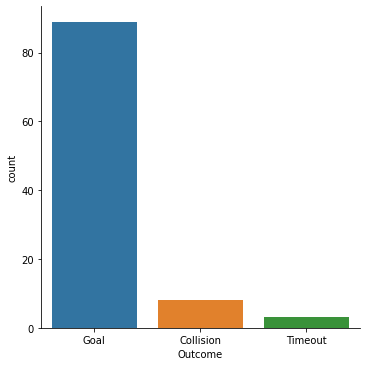

In [6]:
sns.catplot(x="Outcome", data=simulation, order=["Goal", "Collision", "Timeout" ], kind="count")

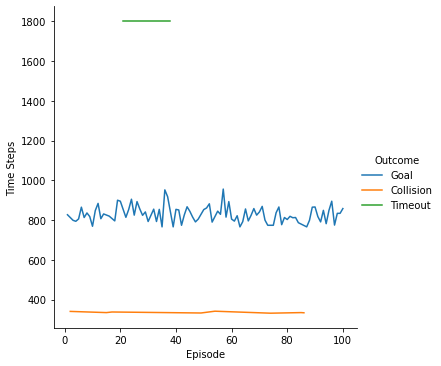

In [7]:
sns.relplot(x="Episode", y="Time Steps", data=simulation, 
            kind ="line", 
            hue="Outcome", 
            hue_order=["Goal", "Collision", "Timeout" ])

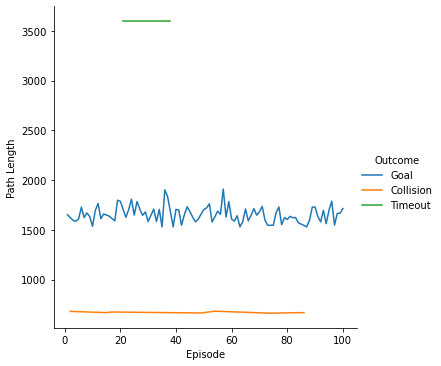

In [8]:
sns.relplot(x="Episode", y="Path Length", data=simulation, 
            kind ="line", 
            hue="Outcome", 
            hue_order=["Goal", "Collision", "Timeout" ],)

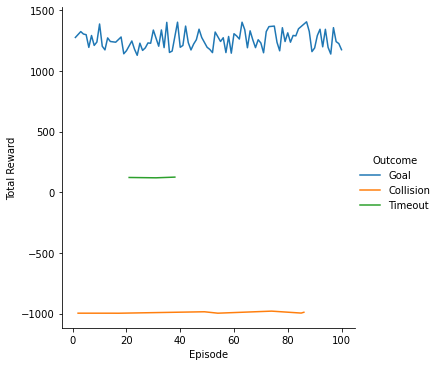

In [9]:
sns.relplot(x="Episode", y="Total Reward", data=simulation, 
            kind ="line", 
            hue="Outcome", 
            hue_order=["Goal", "Collision", "Timeout" ])

In [10]:
# Create detailed dataframe

"""
#   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Episode        10 non-null     int64  
 1   Outcome        10 non-null     object 
 2   Total Reward   10 non-null     float64
 3   Time Steps     10 non-null     int64  
 4   Path Length    10 non-null     float64
 5   Path           10 non-null     object 
 6   Traffic Paths  10 non-null     object 
 7   psi            10 non-null     object 
 8   d_sep          10 non-null     object 
 9   a_lat          10 non-null     object 
 10  d_goal         10 non-null     object 
 11  delta_heading  10 non-null     object 
 12  v_closing      10 non-null     object 
 13  d_cpa          10 non-null     object 
 14  d_dev          10 non-null     object 
 15  r_d_goal       10 non-null     object 
 16  r_h_goal       10 non-null     object 
 17  r_d_cpa        10 non-null     object 
 18  r_d_dev        10 non-null     object 
 19  r_step         10 non-null     object 
"""

sim = pd.DataFrame()

e_values, o_values, t_values, l_values, tr_values = [], [], [], [], []
x_values, y_values, tx_values, ty_values = [], [], [], []
psi_values, d_sep_values, a_lat_values, d_goal_values,  = [], [], [], []
delta_heading_values, v_closing_values, d_cpa_values, d_dev_values  = [], [], [], []
r_d_goal_values, r_h_goal_values, r_d_cpa_values, r_d_dev_values, r_step_values = [], [], [], [], []

for index, row in simulation.iterrows():
        e_values += [row["Episode"]] * row["Time Steps"]
        o_values += [row["Outcome"]] * row["Time Steps"]
        t_values += list(range(1, row["Time Steps"]+1))
        l_values += [row["Path Length"]] * row["Time Steps"]
        tr_values += [row["Total Reward"]] * row["Time Steps"]
        x_values += [pos[0] for pos in row["Path"]]
        y_values += [-pos[1] for pos in row["Path"]]
        tx_values += [pos[0] for pos in row["Traffic Paths"][0]]
        ty_values += [-pos[1] for pos in row["Traffic Paths"][0]]
        psi_values += row["psi"]
        d_sep_values += row["d_sep"]
        a_lat_values += row["a_lat"]
        d_goal_values += row["d_goal"]
        delta_heading_values += row["delta_heading"]
        v_closing_values += row["v_closing"]
        d_cpa_values += row["d_cpa"]
        d_dev_values += row["d_dev"]
        r_d_goal_values += row["r_d_goal"]
        r_h_goal_values += row["r_h_goal"]
        r_d_cpa_values += row["r_d_cpa"]
        r_d_dev_values += row["r_d_dev"]
        r_step_values += row["r_step"]
        
sim["Episode"] = e_values
sim["Outcome"] = o_values
sim["Time Steps"] = t_values
sim["Path Length"] = l_values
sim["Total Reward"] = tr_values
sim["x"] = x_values
sim["y"] = y_values
sim["tx"] = tx_values
sim["ty"] = ty_values
sim["psi"] = psi_values
sim["d_sep"] = d_sep_values
sim["a_lat"] = a_lat_values
sim["a_lat_norm"] = sim["a_lat"] / ACC_LAT_LIMIT
sim["d_goal"] = d_goal_values
sim["delta_heading"] = delta_heading_values
sim["v_closing"] = v_closing_values
sim["v_closing_positive"] = sim.apply(lambda row: row["v_closing"] > 0, axis=1)
sim["d_cpa"] = d_cpa_values
sim["d_dev"] = d_dev_values
sim["r_d_goal"] = r_d_goal_values
sim["r_h_goal"] = r_h_goal_values
sim["r_d_cpa"] = r_d_cpa_values
sim["r_d_dev"] = r_d_dev_values
sim["r_step"] = r_step_values

sim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81965 entries, 0 to 81964
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Episode             81965 non-null  int64  
 1   Outcome             81965 non-null  object 
 2   Time Steps          81965 non-null  int64  
 3   Path Length         81965 non-null  float64
 4   Total Reward        81965 non-null  float64
 5   x                   81965 non-null  float64
 6   y                   81965 non-null  float64
 7   tx                  81965 non-null  float64
 8   ty                  81965 non-null  float64
 9   psi                 81965 non-null  float64
 10  d_sep               81965 non-null  float64
 11  a_lat               81965 non-null  float64
 12  a_lat_norm          81965 non-null  float64
 13  d_goal              81965 non-null  float64
 14  delta_heading       81965 non-null  float64
 15  v_closing           81965 non-null  float64
 16  v_cl

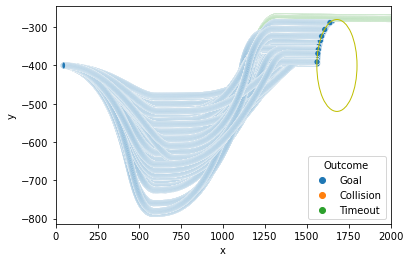

In [11]:
fig, ax = plt.subplots()
plt.xlim(0, 2000)

sns.scatterplot(x="x", y="y", data=sim, ax=ax, 
                hue="Outcome", 
                hue_order=["Goal", "Collision", "Timeout"])

player = plt.Circle((PLAYER_X, -PLAYER_Y), 8)
ax.add_patch(player)

goal = plt.Circle((GOAL_X, -GOAL_Y), GOAL_RADIUS, color='y', fill=False)
ax.add_patch(goal)

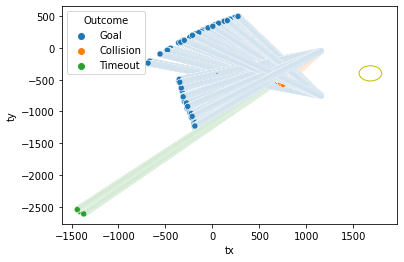

In [12]:
fig, ax = plt.subplots()

sns.scatterplot(x="tx", y="ty", data=sim, ax=ax, 
                hue="Outcome", 
                hue_order=["Goal", "Collision", "Timeout" ])

player = plt.Circle((PLAYER_X, -PLAYER_Y), 8)
ax.add_patch(player)

goal = plt.Circle((GOAL_X, -GOAL_Y), GOAL_RADIUS, color='y', fill=False)
ax.add_patch(goal)

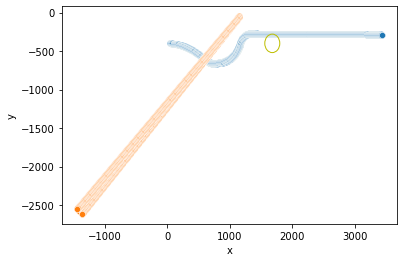

In [13]:
fig, ax = plt.subplots()


sns.scatterplot(x="x", y="y", data=sim[sim["Outcome"]=="Timeout"], ax=ax)
sns.scatterplot(x="tx", y="ty", data=sim[sim["Outcome"]=="Timeout"], ax=ax)

player = plt.Circle((PLAYER_X, -PLAYER_Y), 8)
ax.add_patch(player)

goal = plt.Circle((GOAL_X, -GOAL_Y), GOAL_RADIUS, color='y', fill=False)
ax.add_patch(goal)

<AxesSubplot:xlabel='Time Steps', ylabel='r_step'>

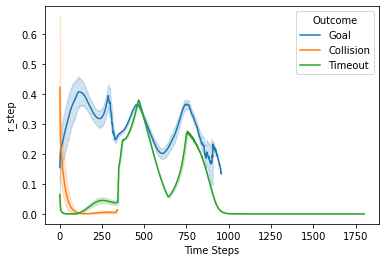

In [14]:
fig, ax = plt.subplots()

# # Ignore high terminal rewards 
# plt.ylim(0, 1)

sns.lineplot(x="Time Steps", y="r_step", data=sim, ax=ax, 
             hue="Outcome", hue_order=["Goal", "Collision", "Timeout" ])

<AxesSubplot:xlabel='Time Steps', ylabel='delta_heading'>

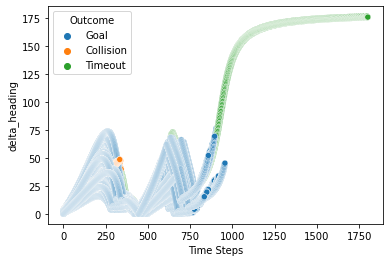

In [15]:
fig, ax = plt.subplots()

sns.scatterplot(x="Time Steps", y="delta_heading", data=sim, ax=ax, 
                hue="Outcome", 
                hue_order=["Goal", "Collision", "Timeout" ])

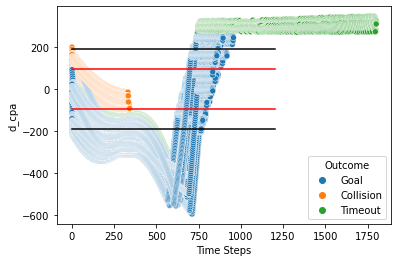

In [16]:
fig, ax = plt.subplots()

sns.scatterplot(x="Time Steps", y="d_cpa", data=sim, ax=ax, 
                hue="Outcome", 
                hue_order=["Goal", "Collision", "Timeout" ])

saf = plt.Line2D([0, 1200], [SAFE_DISTANCE, SAFE_DISTANCE], color="black")
ax.add_line(saf)
col = plt.Line2D([0, 1200], [2*COLLISION_RADIUS, 2*COLLISION_RADIUS], color="red")
ax.add_line(col)
safn = plt.Line2D([0, 1200], [-SAFE_DISTANCE, -SAFE_DISTANCE], color="black")
ax.add_line(safn)
coln = plt.Line2D([0, 1200], [-2*COLLISION_RADIUS, -2*COLLISION_RADIUS], color="red")
ax.add_line(coln)

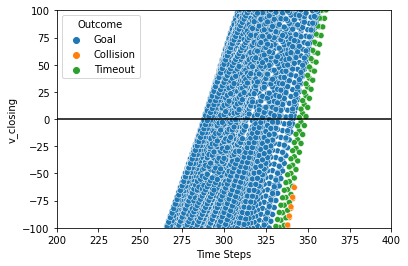

In [27]:
fig, ax = plt.subplots()
plt.ylim(-100, 100)
plt.xlim(200, 400)

sns.scatterplot(x="Time Steps", y="v_closing", data=sim, ax=ax, 
                hue="Outcome", 
                hue_order=["Goal", "Collision", "Timeout" ])

resolution = plt.Line2D([0, 1200], [0, 0], color="black")
ax.add_line(resolution)

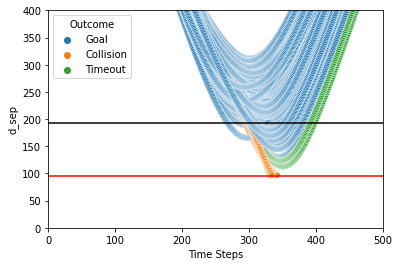

In [24]:
fig, ax = plt.subplots()
plt.ylim(0, 400)
plt.xlim(0, 500)

sns.scatterplot(x="Time Steps", y="d_sep", data=sim, ax=ax, 
                hue="Outcome", 
                hue_order=["Goal", "Collision", "Timeout" ])

saf = plt.Line2D([0, 1200], [SAFE_DISTANCE, SAFE_DISTANCE], color="black")
ax.add_line(saf)
col = plt.Line2D([0, 1200], [2*COLLISION_RADIUS, 2*COLLISION_RADIUS], color="red")
ax.add_line(col)

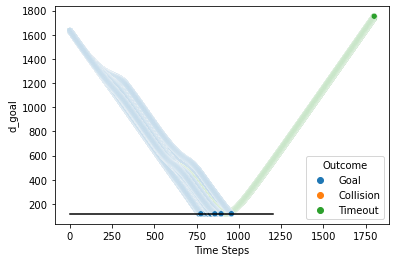

In [19]:
fig, ax = plt.subplots()

sns.scatterplot(x="Time Steps", y="d_goal", data=sim, ax=ax, 
                hue="Outcome", 
                hue_order=["Goal", "Collision", "Timeout" ])

goal = plt.Line2D([0, 1200], [GOAL_RADIUS, GOAL_RADIUS], color="black")
ax.add_line(goal)

<AxesSubplot:xlabel='Time Steps', ylabel='a_lat_norm'>

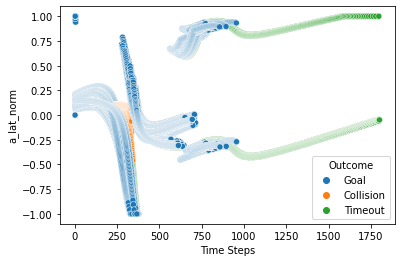

In [20]:
fig, ax = plt.subplots()

sns.scatterplot(x="Time Steps", y="a_lat_norm", data=sim, ax=ax, 
                hue="Outcome", 
                hue_order=["Goal", "Collision", "Timeout" ])

In [21]:
# a_lats = sim[sim["Episode"]==1]["a_lat"]
 
# actions = [x/ACC_LAT_LIMIT for x in a_lats]

# print(actions)